In [ ]:
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import os
import numpy as np
from matplotlib.ticker import MultipleLocator
import os
import config
import utils as ut

2025-10-05 23:13:18.105258: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 23:13:18.140492: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 23:13:18.141100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 23:13:21.696875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# function to perform analysis of efficiency results
def analyzeResults(pt, pt_bins, results):
    acc0, acc0_errs = [], [] # High pT accuracy
    acc1, acc1_errs = [], [] # Low pT negative accuracy
    acc2, acc2_errs = [], [] # Low pT positive accuracy
    for acc, acc_errs, label in zip([acc0, acc1, acc2], [acc0_errs, acc1_errs, acc2_errs], [0, 1, 2]):
        # loop over the pT bins
        for i in range(len(pt_bins) - 1):
            in_bin_extracted = (pt >= pt_bins[i]) & (pt < pt_bins[i+1])
            N = np.sum(in_bin_extracted)
            if np.sum(in_bin_extracted) > 0:
                # Check how many were correctly labeled correctly
                predicted_label = (results[in_bin_extracted] == label)
                npass = np.sum(predicted_label)
                eff = npass / N
                eff_err = efficiency_error(eff, N)
                # save
                acc.append(eff)
                acc_errs.append(eff_err)
            else:
                acc.append(0)
                acc_errs.append(0)
    
    # Calculate performance metrics
    high_pT = (pt > 2)
    low_pT = (pt <= 2)
    high_pT_pred = (results == 0)
    low_pT_pred = (results == 1) | (results == 2)
    signal_efficiency = np.sum(high_pT & high_pT_pred) / np.sum(high_pT)
    background_rejection = np.sum(low_pT & low_pT_pred) / np.sum(low_pT)
    data_reduction = np.sum(low_pT_pred) / len(pt)
    return np.array(acc0), np.array(acc0_errs), np.array(acc1), np.array(acc1_errs), np.array(acc2), np.array(acc2_errs), signal_efficiency, background_rejection, data_reduction

# Calculate the difference in event-by-event yprofiles and quantify the difference by summing across all 16 rows of the yprofile for each event
def yprofile_difference(pt, pt_bins, results_true, results):
    difference = []
    difference_err = []
    # loop over the pT bins
    for i in range(len(pt_bins) - 1):
        in_bin_extracted = (pt >= pt_bins[i]) & (pt < pt_bins[i+1])
        N = np.sum(in_bin_extracted)
        if N > 0:
            # Extract the yprofiles for the events in the current bin
            true_profiles = results_true[in_bin_extracted]  # Shape: (N, 16)
            predicted_profiles = results[in_bin_extracted]  # Shape: (N, 16)
            # Compute the event-by-event difference and sum across 16 rows
            event_differences = np.sum(np.abs(true_profiles - predicted_profiles), axis=1)  # Shape: (N,)

            # Average the summed differences for the current bin
            average_difference = np.mean(event_differences)
            difference.append(average_difference)
            difference_err.append(0)
        else:
            # If no events in the bin, append 0
            difference.append(0)
            difference_err.append(0)

    return difference

# efficiency error calculation
def efficiency_error(eff, N):
    ''' 
    See section 2.2.1 https://lss.fnal.gov/archive/test-tm/2000/fermilab-tm-2286-cd.pdf
    eff = estimate of the efficiency
    N = sample size
    '''
    return np.sqrt(eff * (1 - eff) / N)

## Load DNN results and y-profiles
Once the readout.csv is produced, it is passed to CMSPIX_DAQ/lab_analysis/dynamic_parseDNNresults.py to obtain final_results.npy (DNN results in 0/1/2 format).

In [ ]:
confs = config.confs_TB1_BDtuning4_TS20 #config.confs_TB1_BDtuning4_TS20 # confs_TB1_ABtuning # confs_TB1_BDtuning # 

save_dir = 'newFNALmodels/'
# save_dir = 'tmp_Noise2400e-/newFNALmodels/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
suffix = ""
# suffix = 'model1'

datadir = f"/asic/projects/C/CMS_PIX_28/dshekar/filter/model_pipeline/tmp_21x13"
# datadir = f"/asic/projects/C/CMS_PIX_28/dshekar/filter/model_pipeline/tmp_Noise2400e-/tmp_21x13_noise0"

for conf in confs:
    dir = os.path.join(datadir, "_".join(map(str, conf["qm_charge_levels"])))
    conf["pt"] = np.load(os.path.join(dir, "pts.npy"))
    conf["ylocals"] = np.load(os.path.join(dir, "ylocals.npy"))
    conf["clslabels"] = np.load(os.path.join(dir, "clslabels.npy"))
    conf["yprofiles"] = np.load(os.path.join(dir, "yprofiles.npy"))
    conf["keras_predictions"] = np.load(os.path.join(dir, "keras_predictions.npy"))
    conf["keras_predictions"] = np.argmax(conf["keras_predictions"], axis=1)
    conf["qkeras_predictions"] = np.load(os.path.join(dir, "qkeras_predictions.npy"))
    conf["qkeras_predictions"] = np.argmax(conf["qkeras_predictions"], axis=1)
    conf["asic_predictions"] = np.load(conf["asic_path"])
    conf["asic_yprofiles"] = np.loadtxt(conf["asic_yprofiles_path"], delimiter=",")
    conf["noise_yprofile"] = []
    print(conf["asic_predictions"].shape)

(150000,)


## Plot y-profile distribution

Text(1, 0, 'y-local [mm]')

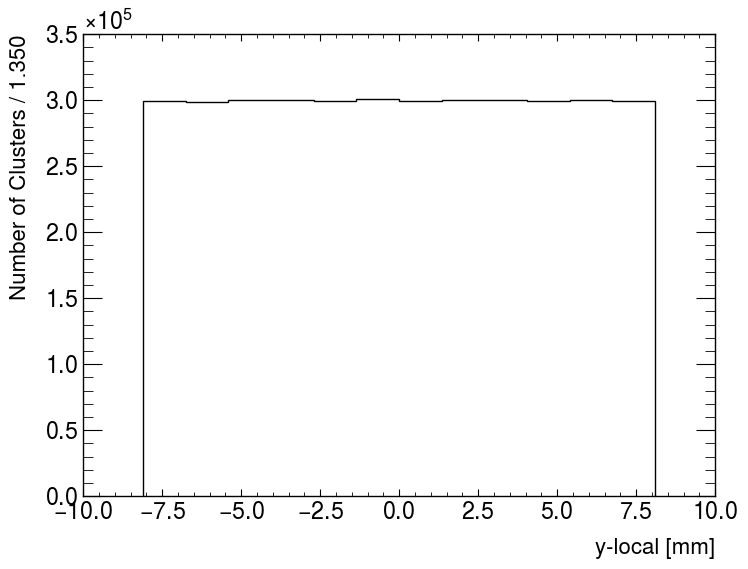

In [ ]:
# plot ylocals
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(-8.1, 8.1, 13)
bw = bins[1] - bins[0]
ax.hist(confs[0]["ylocals"], bins=bins, histtype='step', color='black')
ax.set_ylabel(f"Number of Clusters / {bw:.3f}", fontsize=16)
ax.set_xlabel("y-local [mm]", fontsize=16)


## Accuracy results of the DNN


Dataset:  [1000, 1600, 2400] , size of asic results =  (150000,) , total size of dataset =  299739
QKeras signal efficiency = 91.56%, background rejection = 44.57%, data reduction = 44.57%
ASIC signal efficiency = 78.91%, background rejection = 45.42%, data reduction = 45.42%


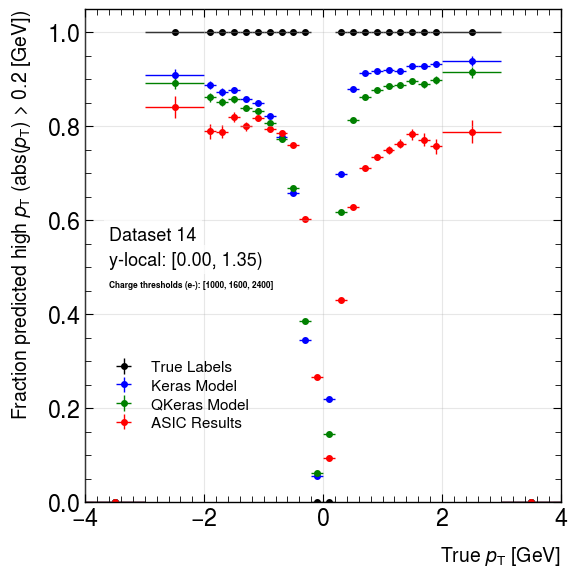


Dataset:  [1000, 1600, 2400] , size of asic results =  (150000,) , total size of dataset =  299739
QKeras signal efficiency = 91.56%, background rejection = 44.57%, data reduction = 44.57%
ASIC signal efficiency = 78.91%, background rejection = 45.42%, data reduction = 45.42%


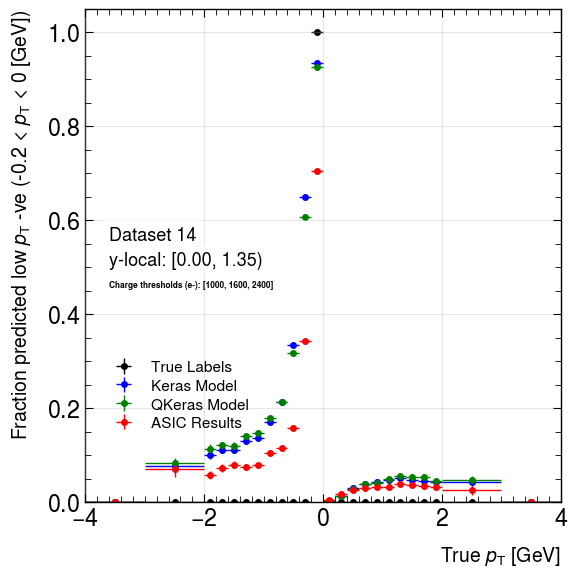


Dataset:  [1000, 1600, 2400] , size of asic results =  (150000,) , total size of dataset =  299739
QKeras signal efficiency = 91.56%, background rejection = 44.57%, data reduction = 44.57%
ASIC signal efficiency = 78.91%, background rejection = 45.42%, data reduction = 45.42%


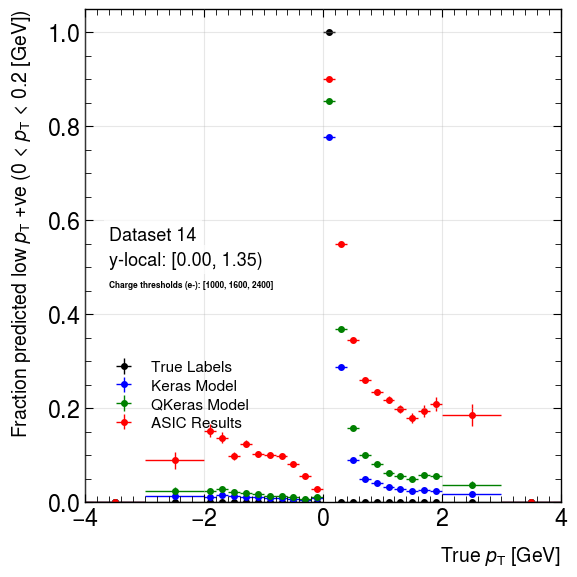

[0, 10.65891472868217, 10.611280487804878, 10.669230769230769, 10.726762820512821, 10.592311857065512, 10.511430437622469, 10.48271092669433, 10.39357010213556, 10.252743436588416, 9.968639214616854, 9.34157342862164, 12.177946324387397, 11.931080521154643, 11.51425400568773, 11.339895165987187, 11.217038940502075, 11.093174061433448, 11.015112037519541, 11.02653399668325, 11.010893246187363, 10.927246790299572, 11.094545454545454, 0]


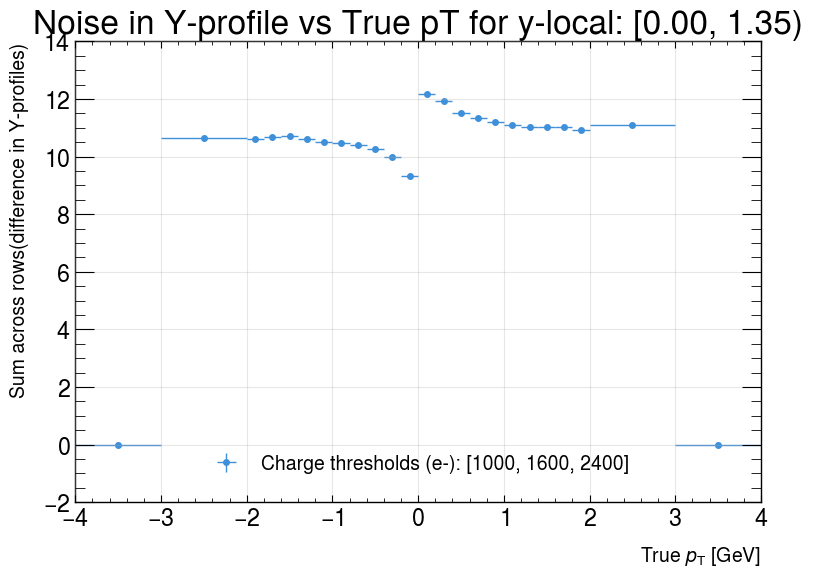

In [ ]:
from PyPDF2 import PdfMerger

# Create bins for true pT values from -4 to 4
bins_pos = np.unique(np.concatenate([
    np.linspace(0, 1, 5, endpoint=False),
    np.linspace(1, 2, 5, endpoint=False),
    np.linspace(2, 4, 3, endpoint=True)
]))
bins_neg = -1 * bins_pos[::-1]
pt_bins = np.unique(np.concatenate([bins_neg, bins_pos]))
bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
bin_widths = np.diff(pt_bins)

# binNumberList = range(len(bins) - 1) # full range
binNumberList = [6] # just the 0th bin, as chosen by Giuseppe
label_names = ['high $p_{\mathrm{T}}$ (abs($p_{\mathrm{T}}$) > 0.2 [GeV])', 'low $p_{\mathrm{T}}$ -ve (-0.2 < $p_{\mathrm{T}}$ < 0 [GeV])', 'low $p_{\mathrm{T}}$ +ve (0 < $p_{\mathrm{T}}$ < 0.2 [GeV])']  # replace with your label meaning
DNNlabels = [0,1,2]
for bin_number in binNumberList:
    ylocal_min = bins[bin_number]
    ylocal_max = bins[bin_number + 1]
    for iL in DNNlabels:
        fig, ax = plt.subplots(figsize=(6,6))

        ax.text(0.05, 0.56, f"Dataset 14", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        ax.text(0.05, 0.51, f"y-local: [{ylocal_min:.2f}, {ylocal_max:.2f})", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        # ax.text(0.05, 0.48, f"Label {iL}: {label_names[iL]}", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        for iC, conf in enumerate(confs):
            mask = (conf["ylocals"] >= ylocal_min) & (conf["ylocals"] < ylocal_max)
            true_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["clslabels"][mask])
            keras_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["keras_predictions"][mask])
            qkeras_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["qkeras_predictions"][mask])
            asic_res_bin = analyzeResults(conf["pt"][mask][:conf["asic_predictions"].shape[0]], pt_bins[:conf["asic_predictions"].shape[0]], conf["asic_predictions"])
            noise_yprofile = yprofile_difference(conf["pt"][mask][:conf["asic_predictions"].shape[0]], pt_bins[:conf["asic_predictions"].shape[0]], conf["yprofiles"][mask][:conf["asic_yprofiles"].shape[0]], conf["asic_yprofiles"])
            conf["noise_yprofile"] = noise_yprofile
            print(f"")
            print("Dataset: ",conf["qm_charge_levels"],", size of asic results = ", conf["asic_predictions"].shape, ", total size of dataset = ", mask.sum())
            # return np.array(acc0), np.array(acc0_errs), np.array(acc1), np.array(acc1_errs), np.array(acc2), np.array(acc2_errs), signal_efficiency, background_rejection, data_reduction
            print(f"QKeras signal efficiency = {qkeras_res_bin[2*len(DNNlabels)] * 100:.2f}%, background rejection = {qkeras_res_bin[2*len(DNNlabels)+1] * 100:.2f}%, data reduction = {qkeras_res_bin[2*len(DNNlabels)+1] * 100:.2f}%")
            
            print(f"ASIC signal efficiency = {asic_res_bin[2*len(DNNlabels)] * 100:.2f}%, background rejection = {asic_res_bin[2*len(DNNlabels)+1] * 100:.2f}%, data reduction = {asic_res_bin[2*len(DNNlabels)+1] * 100:.2f}%")
            # plot settings
            light = (conf["qm_charge_levels"] == [400, 1600, 2400])
            light2 = (conf["qm_charge_levels"] == [700, 1600, 2400])
            alpha = 1
            if light: alpha = 0.2  # make the first configuration more transparent
            if light2: alpha = 0.5  # make the second configuration more transparent
            labels = [ "True Labels", "Keras Model", "QKeras Model", "ASIC Results"]
            if light or light2:
                labels = ["" for _ in labels]  # hide labels for the first configuration

            # get accuracy and error for label iL
            ax.errorbar(bin_centers, true_res_bin[2*iL], xerr=bin_widths/2, yerr=true_res_bin[2*iL+1], fmt='o', linewidth=1, markersize=4, color="black", label=labels[0], alpha=alpha)
            ax.errorbar(bin_centers, keras_res_bin[2*iL], xerr=bin_widths/2, yerr=keras_res_bin[2*iL+1], fmt='o', linewidth=1, markersize=4, color="blue", label=labels[1], alpha=alpha)
            ax.errorbar(bin_centers, qkeras_res_bin[2*iL], xerr=bin_widths/2, yerr=qkeras_res_bin[2*iL+1], fmt='o', linewidth=1, markersize=4, color="green", label=labels[2], alpha=alpha)
            ax.errorbar(bin_centers, asic_res_bin[2*iL], xerr=bin_widths/2, yerr=asic_res_bin[2*iL+1], fmt='o', linewidth=1, markersize=4, color="red", label=labels[3], alpha=alpha)
            ax.text(0.05, 0.45 - iC*0.03, f"Charge thresholds (e-): {conf['qm_charge_levels']}", transform=ax.transAxes, fontsize=6, verticalalignment='top', fontweight='bold', alpha=alpha)

        ax.set_xlabel(r'True $p_{\mathrm{T}}$ [GeV]')
        ax.set_ylabel(f'Fraction predicted {label_names[iL]}')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.05)
        ax.set_xlim(-4, 4)
        ax.tick_params(which='minor', length=4)
        ax.tick_params(which='major', length=6)
        ax.xaxis.set_minor_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))

        ax.legend(loc='lower left', fontsize=11, bbox_to_anchor=(0, 0.1))
        plt.tight_layout()
        plt.show()

        # os.makedirs(f"plots", exist_ok=True)
        pdf_filename = f"{save_dir}/eff_vs_pt_ylocal_bin_{bin_number}_label_{iL}_{suffix}.pdf"
        fig.savefig(pdf_filename)

    plt.figure(2)
    for iC, conf in enumerate(confs):
        print(conf["noise_yprofile"])
        plt.errorbar(bin_centers, conf["noise_yprofile"], xerr=bin_widths/2, yerr=0, label=f"Charge thresholds (e-): {conf['qm_charge_levels']}", fmt='o', linewidth=1, markersize=4)
    plt.xlabel(r'True $p_{\mathrm{T}}$ [GeV]')
    plt.ylabel("Sum across rows(difference in Y-profiles)")
    plt.grid(True, alpha=0.3)
    plt.title(f"Noise in Y-profile vs True pT for y-local: [{ylocal_min:.2f}, {ylocal_max:.2f})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_dir}/noise_in_yprofile_ylocal_bin_{bin_number}_{suffix}.pdf")

# After the loop, concatenate all PDFs into one (run this after the loop)
if len(binNumberList) > 1:
    merger = PdfMerger()
    pdf_files = [f"{save_dir}/eff_vs_pt_ylocal_bin_{i}_{suffix}.pdf" for i in binNumberList]
    for pdf in pdf_files:
        merger.append(pdf)
    merger.write(f"{save_dir}/all_eff_vs_pt_ylocal_bins_{suffix}.pdf")
    merger.close()

## Accuracy results of DNN results from  w/ and w/o noise yprofile subsets
The result form the above plot will be referred to as "ASIC Results".
Owing to noise from electronics/chip and charge-injection imperfections, the y-profile sent as input to the DNN might not match the original simulated y-profile. Accuracy results for a subset of data where the injected and simulated y-profiles match are produced and are labeled as "ASIC Results (no noise)".

Bin 6: 299739 entries in ylocal range [0.00, 1.35)
asserting shapes:  (299739, 16) (150000, 16)
Number of events with the same y-profiles (between simulation and injected into ASIC) =  0


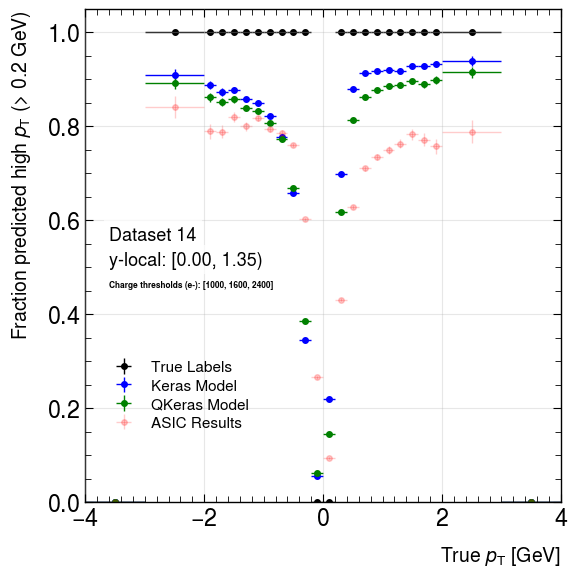

In [ ]:
from PyPDF2 import PdfMerger

# Create bins for true pT values from -4 to 4
bins_pos = np.unique(np.concatenate([
    np.linspace(0, 1, 5, endpoint=False),
    np.linspace(1, 2, 5, endpoint=False),
    np.linspace(2, 4, 3, endpoint=True)
]))
bins_neg = -1 * bins_pos[::-1]
pt_bins = np.unique(np.concatenate([bins_neg, bins_pos]))
bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
bin_widths = np.diff(pt_bins)

# binNumberList = range(len(bins) - 1) # full range
binNumberList = [6] # just the 0th bin, as chosen by Giuseppe
# plot per configuration
for iC, conf in enumerate(confs):
    for bin_number in binNumberList:
    
        # Select the range of the i-th bin of ylocal
        ylocal_min = bins[bin_number]
        ylocal_max = bins[bin_number + 1]
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(6,6))

        # Add text for ylocal bin range
        ax.text(0.05, 0.56, f"Dataset 14", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        ax.text(0.05, 0.51, f"y-local: [{ylocal_min:.2f}, {ylocal_max:.2f})", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    

    # interested_range = (ylocal_min, ylocal_max)
    mask = (conf["ylocals"] >= ylocal_min) & (conf["ylocals"] < ylocal_max)
    print(f"Bin {bin_number}: {mask.sum()} entries in ylocal range [{ylocal_min:.2f}, {ylocal_max:.2f})")
    
    # Find number of events with the same intended and injected input to the DNN (y-profile)
    print("asserting shapes: ", (conf["yprofiles"][mask]).shape, conf["asic_yprofiles"].shape)
    mask_noNoiseInjected = np.all(conf["yprofiles"][mask][:conf["asic_predictions"].shape[0]] == conf["asic_yprofiles"], axis=1)
    print("Number of events with the same y-profiles (between simulation and injected into ASIC) = ", mask_noNoiseInjected.sum())
    
    # results
    true_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["clslabels"][mask])
    keras_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["keras_predictions"][mask])
    qkeras_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["qkeras_predictions"][mask])
    asic_res_bin = analyzeResults(conf["pt"][mask][:conf["asic_predictions"].shape[0]], pt_bins[:conf["asic_predictions"].shape[0]], conf["asic_predictions"])

    if(mask_noNoiseInjected.sum() != 0):
        conf["asic_predictions_yprofileMatch"] = conf["asic_predictions"][mask_noNoiseInjected][:mask_noNoiseInjected.sum()]
        conf["pt_inYrange"] = conf["pt"][mask][:mask.sum()]
        print(conf["pt_inYrange"].shape)
        asic_noNoiseInjected_res_bin = analyzeResults(conf["pt_inYrange"][mask_noNoiseInjected][:mask_noNoiseInjected.sum()], pt_bins, conf["asic_predictions_yprofileMatch"])

    # plot settings
    # light = (conf["qm_charge_levels"] == [400, 1600, 2400])
    alpha = 1.0 #0.2 if light else 1.0  # make the first configuration more transparent
    labels = [ "True Labels", "Keras Model", "QKeras Model", "ASIC Results", "ASIC Results (no noise)"]
    # if light:
    #     labels = ["" for _ in labels]  # hide labels for the first configuration
    
    # plot error bars
    ax.errorbar(bin_centers, true_res_bin[0], xerr=bin_widths/2, yerr=true_res_bin[1], fmt='o', linewidth=1, markersize=4, color="black", label=labels[0], alpha=alpha)
    ax.errorbar(bin_centers, keras_res_bin[0], xerr=bin_widths/2, yerr=keras_res_bin[1], fmt='o', linewidth=1, markersize=4, color="blue", label=labels[1], alpha=alpha)
    ax.errorbar(bin_centers, qkeras_res_bin[0], xerr=bin_widths/2, yerr=qkeras_res_bin[1], fmt='o', linewidth=1, markersize=4, color="green", label=labels[2], alpha=alpha)
    ax.errorbar(bin_centers, asic_res_bin[0], xerr=bin_widths/2, yerr=asic_res_bin[1], fmt='o', linewidth=1, markersize=4, color="red", label=labels[3], alpha=0.2)
    if(mask_noNoiseInjected.sum() != 0):
        ax.errorbar(bin_centers, asic_noNoiseInjected_res_bin[0], xerr=bin_widths/2, yerr=asic_noNoiseInjected_res_bin[1], fmt='o', linewidth=1, markersize=4, color="red", label=labels[4], alpha=alpha)

    ax.text(0.05, 0.45 - iC*0.03, f"Charge thresholds (e-): {conf['qm_charge_levels']}", transform=ax.transAxes, fontsize=6, verticalalignment='top', fontweight='bold', alpha=alpha)


    # set plot styles
    ax.set_xlabel(r'True $p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel(r'Fraction predicted high $p_{\mathrm{T}}$ (> 0.2 GeV)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-4, 4)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=6)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))

    ax.legend(loc='lower left', fontsize=11, bbox_to_anchor=(0, 0.1))
    plt.tight_layout()
    plt.show()

    # # Create 'plots' directory if it doesn't exist
    # os.makedirs("plots", exist_ok=True)

    # Save the current figure as a PDF in the 'plots' directory
    pdf_filename = f'{save_dir}/noisyAndNoNoise_{conf["qm_charge_levels"][0]}e-Thresh_eff_vs_pt_ylocal_bins_{suffix}.pdf'
    fig.savefig(pdf_filename)

    # # After the loop, concatenate all PDFs into one (run this after the loop)
    # if len(binNumberList) > 1:
    #     merger = PdfMerger()
    #     pdf_files = [f"plots/eff_vs_pt_ylocal_bin_{i}.pdf" for i in binNumberList]
    #     for pdf in pdf_files:
    #         merger.append(pdf)
    #     merger.write(f'plots/noisyAndNoNoise_{conf["qm_charge_levels"][0]}e-Thresh_eff_vs_pt_ylocal_bins.pdf')
    #     merger.close()
